In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [28]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
     BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/mobile_prices.csv').dropna()
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.51850,439.418206,501.0,851.75,1226.0,1615.25,1998.0
blue,2000.0,0.49500,0.500100,0.0,0.00,0.0,1.00,1.0
clock_speed,2000.0,1.52225,0.816004,0.5,0.70,1.5,2.20,3.0
dual_sim,2000.0,0.50950,0.500035,0.0,0.00,1.0,1.00,1.0
fc,2000.0,4.30950,4.341444,0.0,1.00,3.0,7.00,19.0
four_g,2000.0,0.52150,0.499662,0.0,0.00,1.0,1.00,1.0
int_memory,2000.0,32.04650,18.145715,2.0,16.00,32.0,48.00,64.0
m_dep,2000.0,0.50175,0.288416,0.1,0.20,0.5,0.80,1.0
mobile_wt,2000.0,140.24900,35.399655,80.0,109.00,141.0,170.00,200.0
n_cores,2000.0,4.52050,2.287837,1.0,3.00,4.0,7.00,8.0


In [6]:
data.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [7]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Get columns dtypes

In [8]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
Categorical Columns : []


### 3.3. EDA

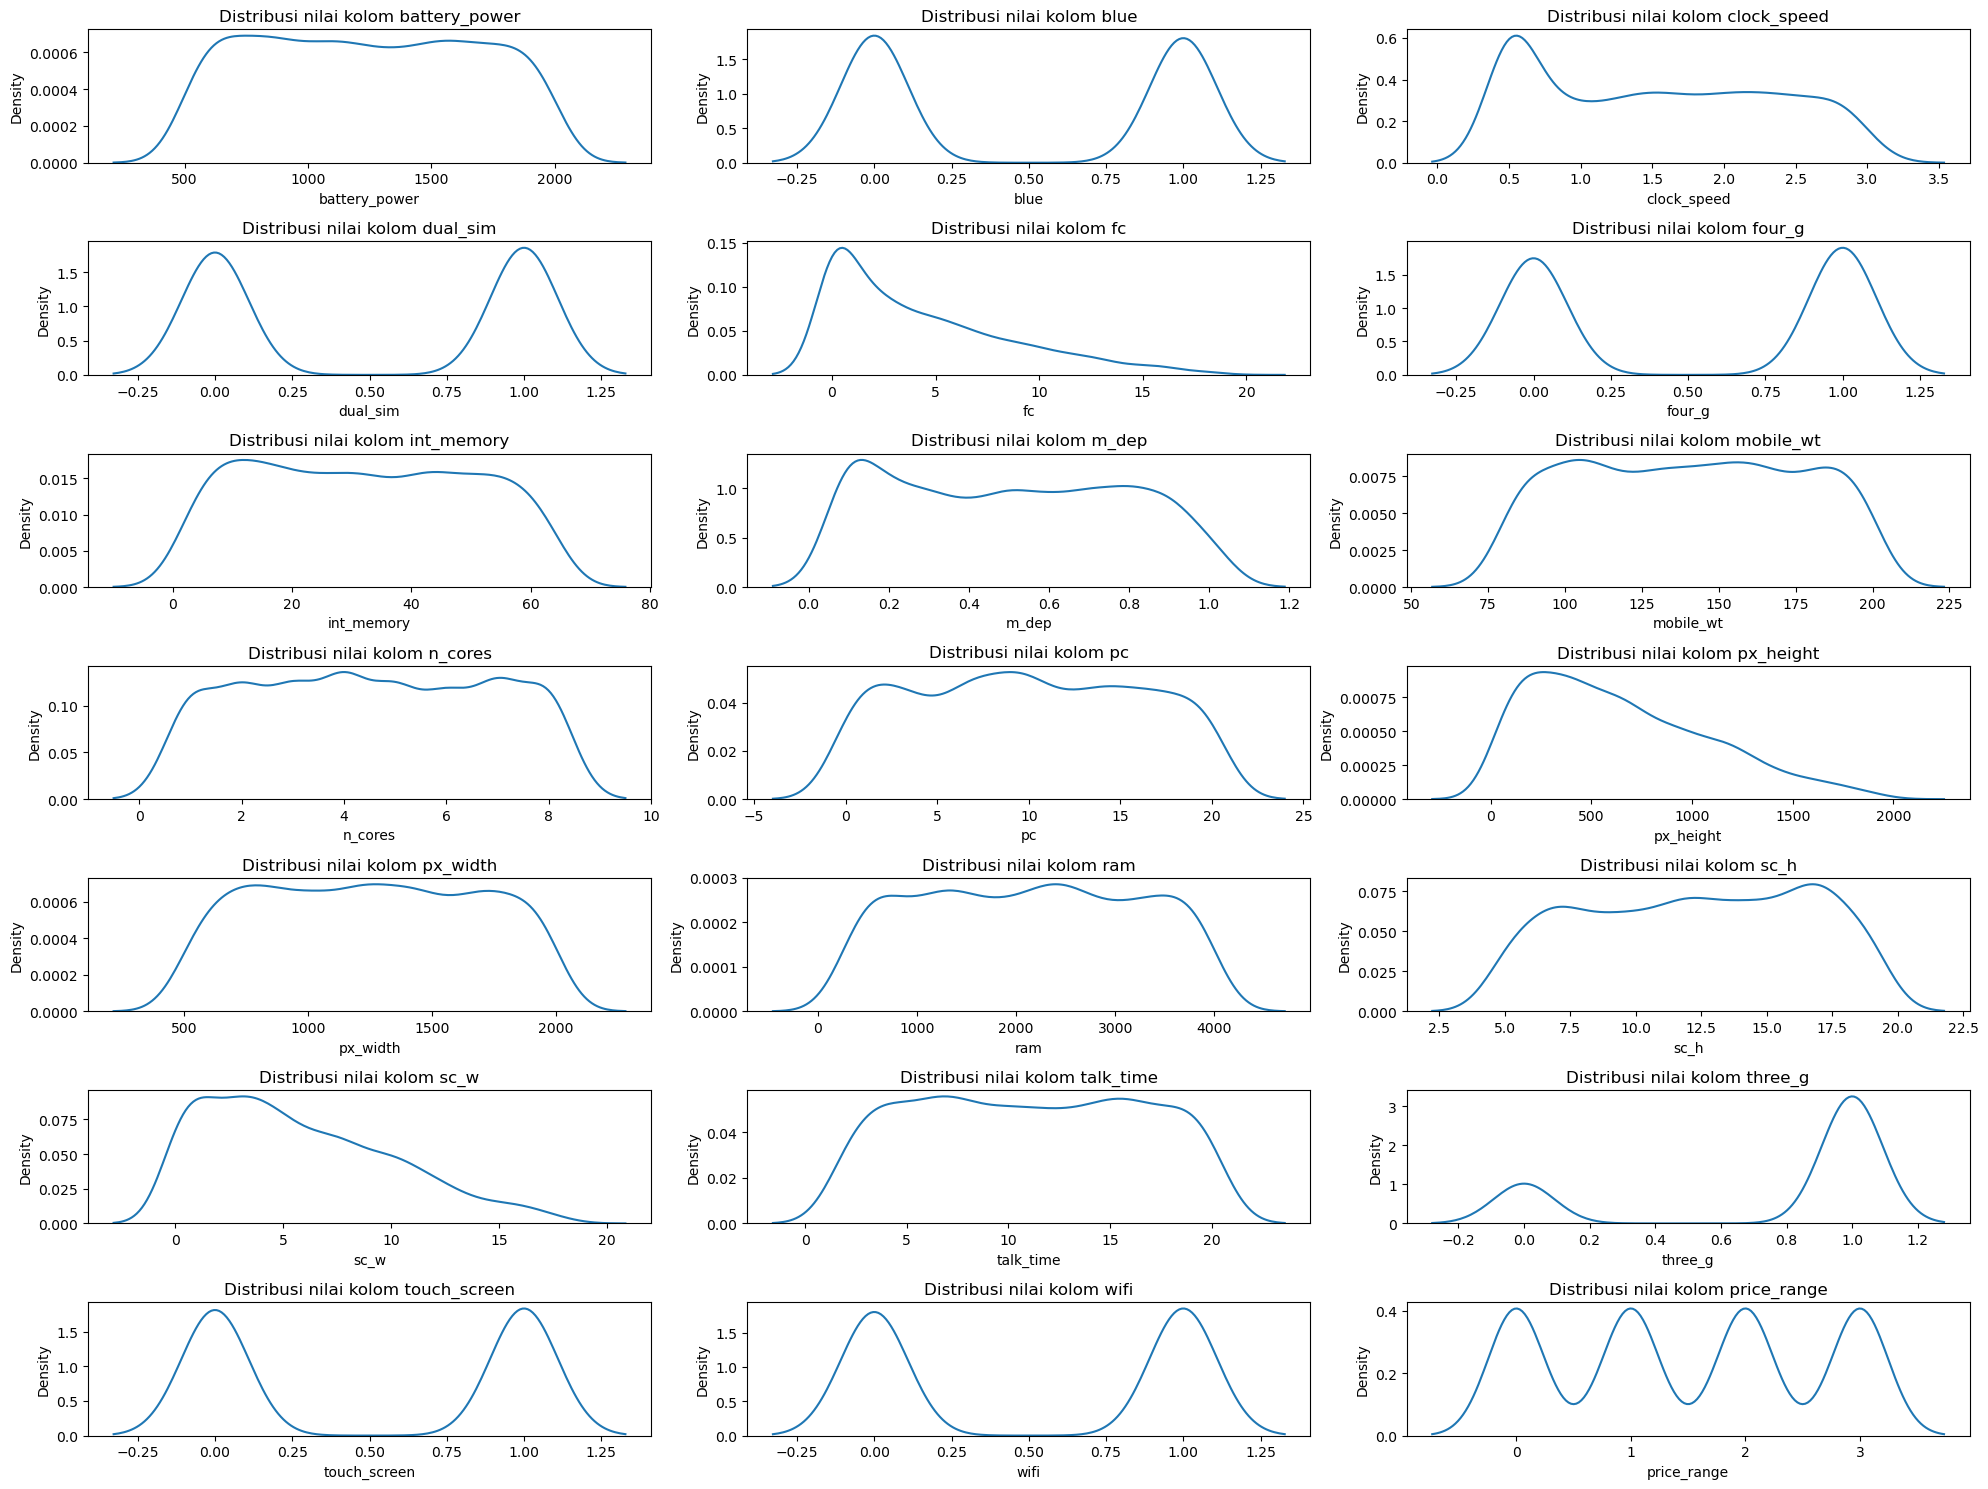

In [11]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

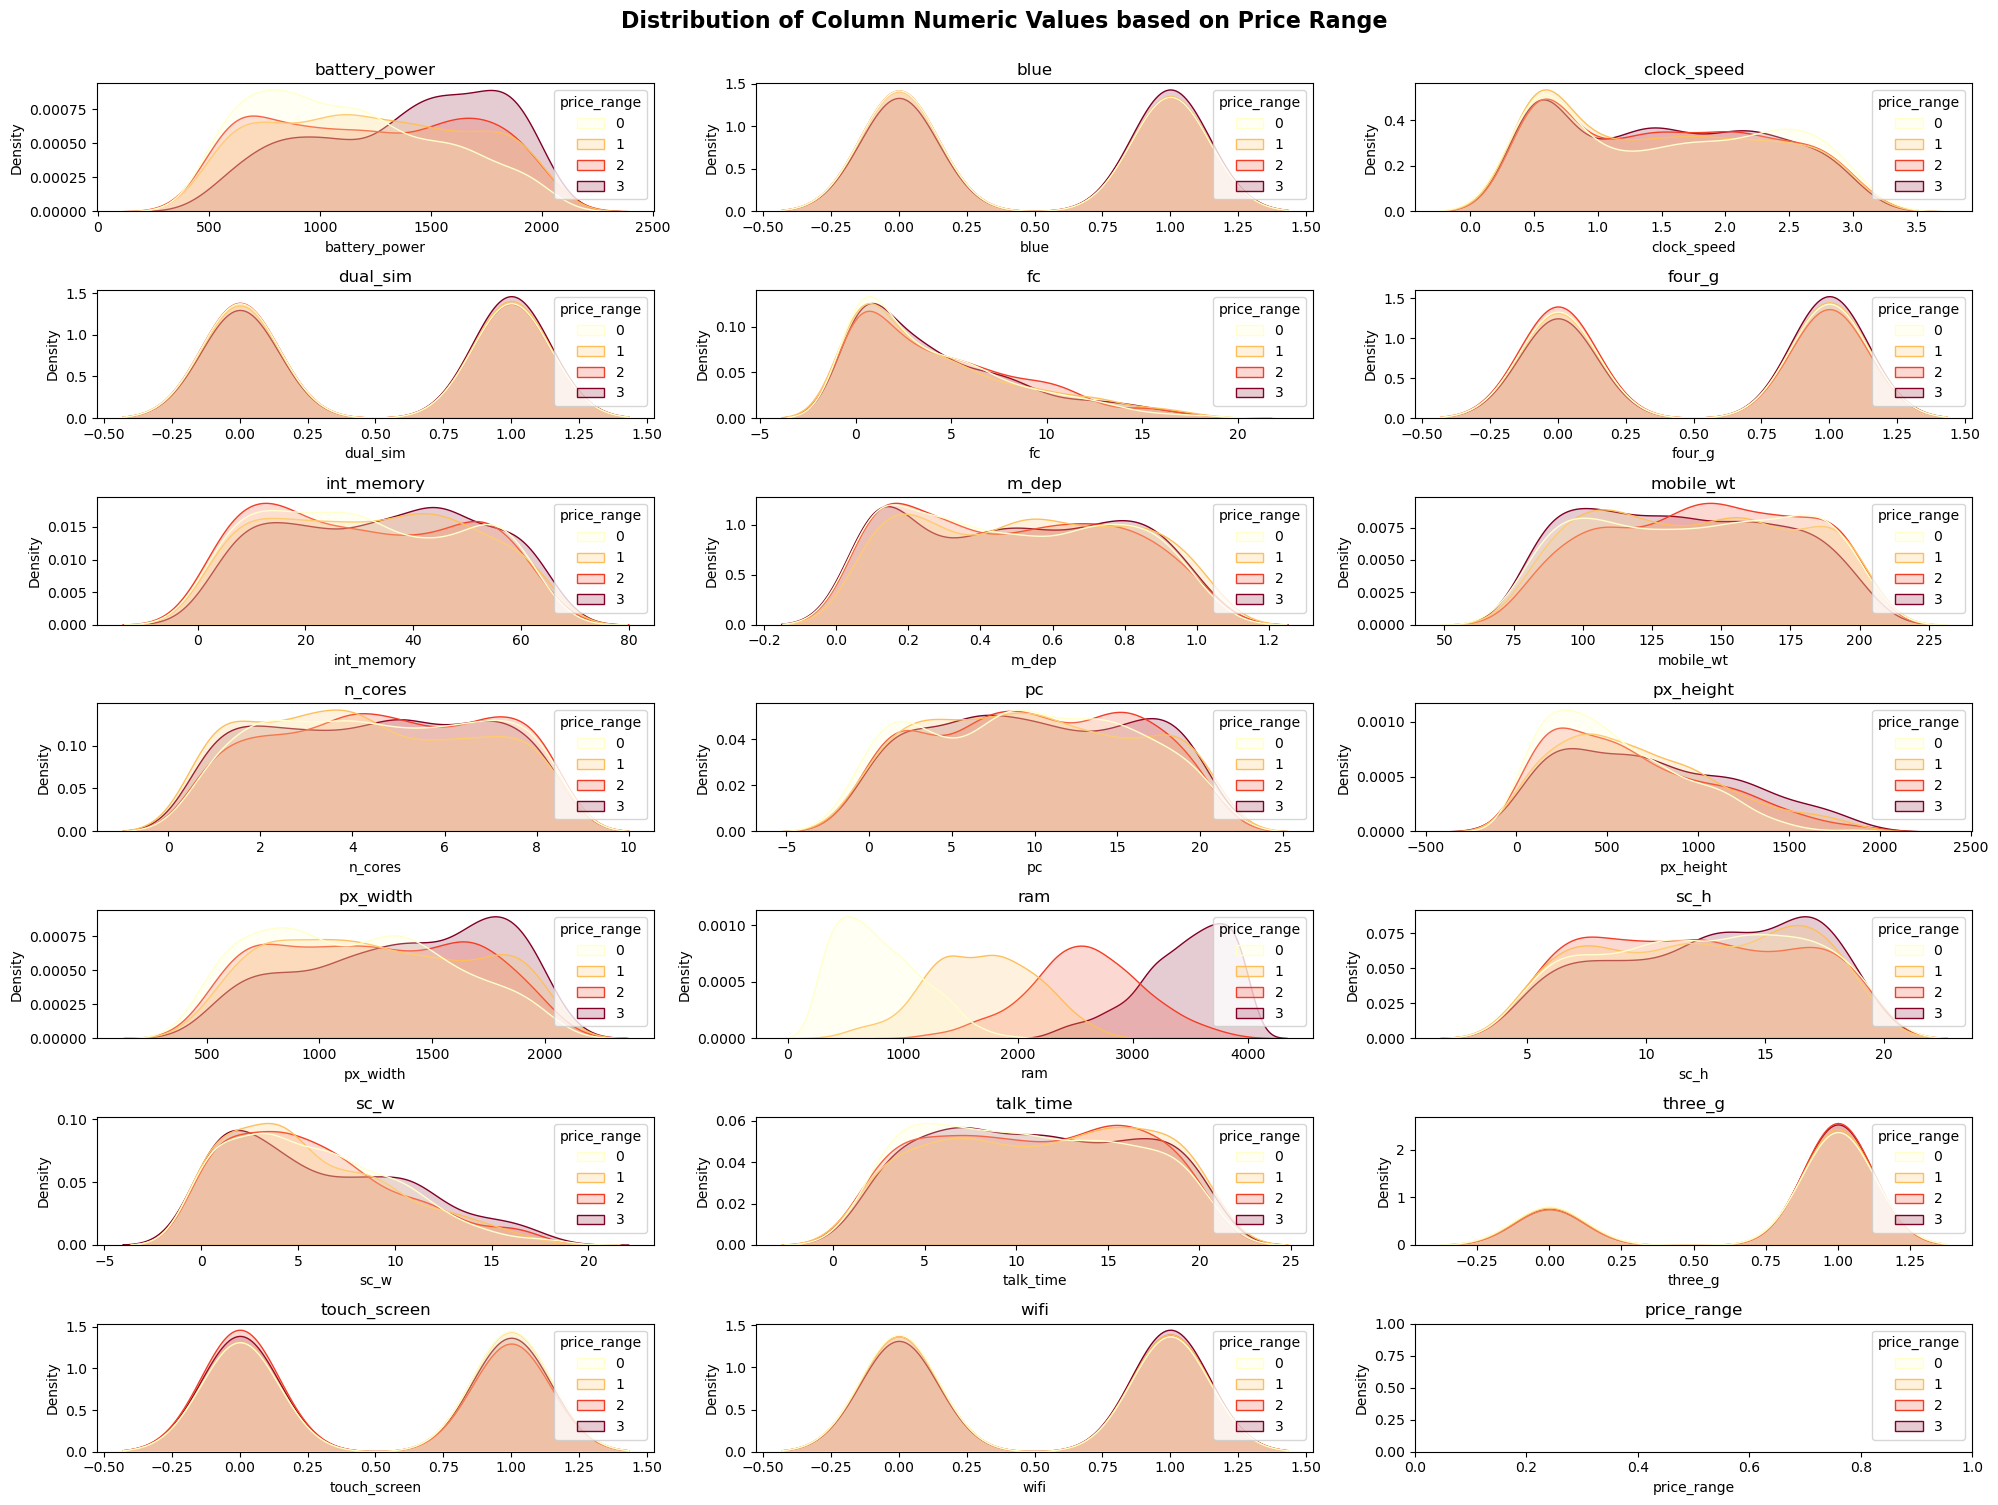

In [14]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="price_range", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Price Range', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

[Text(0, 0, '500'), Text(0, 0, '500'), Text(0, 0, '500'), Text(0, 0, '500')]

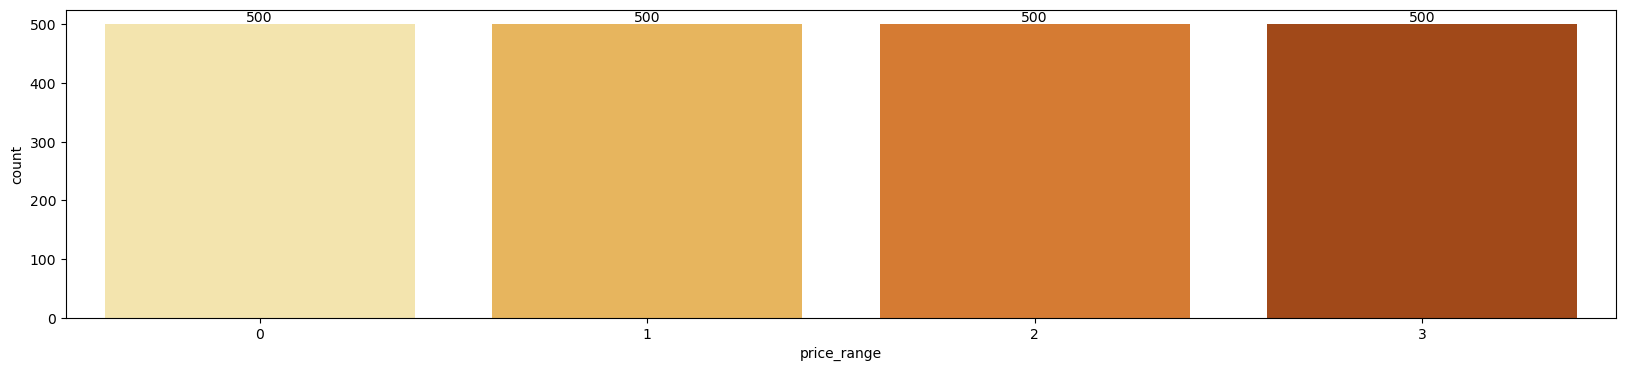

In [15]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'price_range', palette='YlOrBr')
ax.bar_label(ax.containers[0])

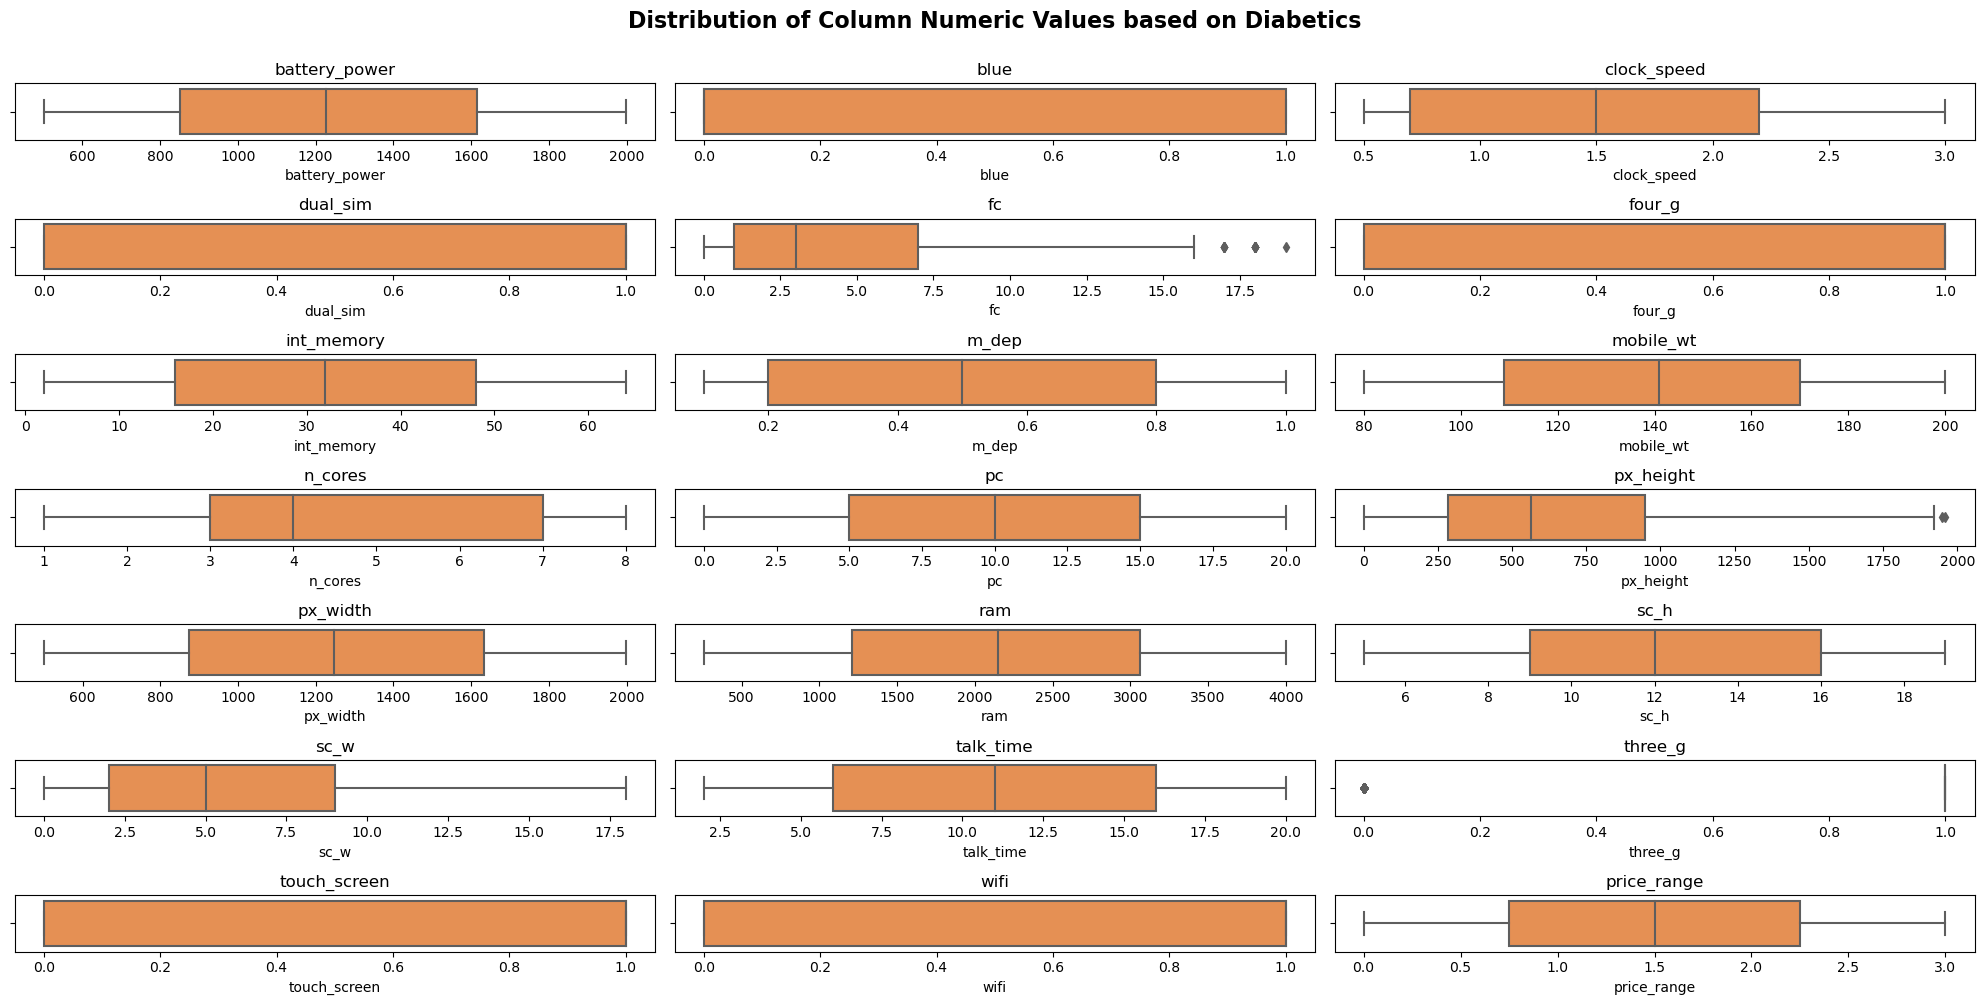

In [17]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

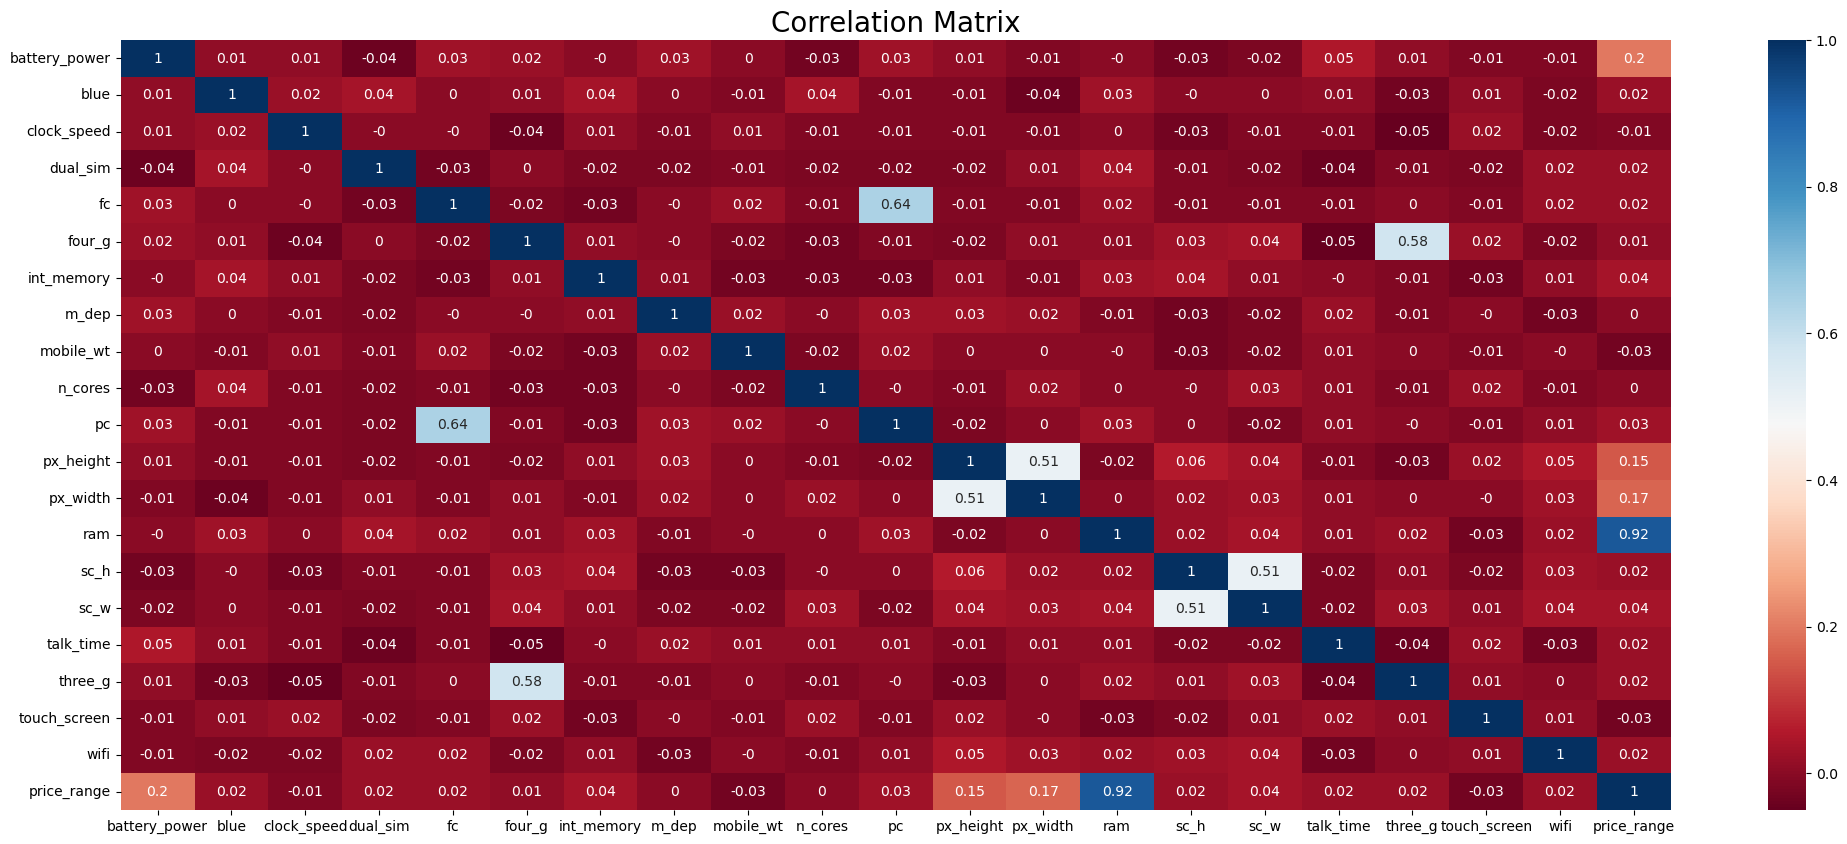

In [18]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.2. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Splitting Train, Test, And Validation data 

# 5 Neural Network Algoritms

In [41]:
X = data.drop(columns=['price_range'])
Y = to_categorical(data['price_range'])

# print(Counter(Y))
# # undersample = RandomUnderSampler()
# undersample = SMOTE()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# Y = to_categorical(Y)

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_val = scalar.transform(X_val)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1404, 20)
(396, 20)
(200, 20)


In [52]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.8))
    model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.8))
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(4, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.000_001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 4096)              86016     
                                                                 
 dense_19 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_20 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_21 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 20,968,332
Trainable params: 20,968,332
Non-trainable params: 0
_________________________________________________________________


In [57]:
num_epoch = 50
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/50
44/44 [==============================] - 1s 10ms/step - loss: 0.5179 - accuracy: 0.9252 - val_loss: 0.5585 - val_accuracy: 0.8662
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.5082 - accuracy: 0.9302 - val_loss: 0.5494 - val_accuracy: 0.8737
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.4992 - accuracy: 0.9338 - val_loss: 0.5408 - val_accuracy: 0.8763
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.4899 - accuracy: 0.9366 - val_loss: 0.5323 - val_accuracy: 0.8788
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.4813 - accuracy: 0.9380 - val_loss: 0.5243 - val_accuracy: 0.8813
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.4727 - accuracy: 0.9430 - val_loss: 0.5161 - val_accuracy: 0.8864
Epoch 7/50
44/44 [==============================] - 0s 10ms/step - loss: 0.4645 - accuracy: 0.9423 - val_loss: 0.5084 - val_accuracy: 0.8864
Epoch 8/50
44

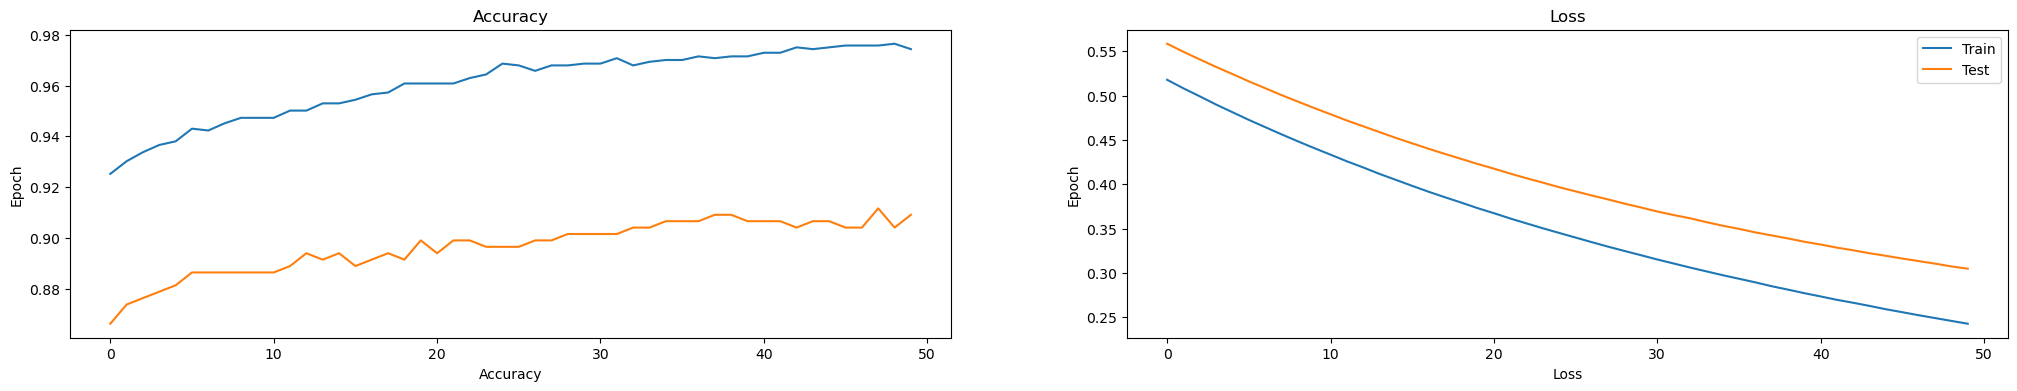

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [59]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val))

print(classification_report(y_val,y_pred))

7/7 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        59
           1       1.00      0.92      0.96        49
           2       0.98      0.93      0.95        45
           3       0.94      0.98      0.96        47

   micro avg       0.97      0.96      0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200
 samples avg       0.96      0.96      0.96       200



c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 21ms/step


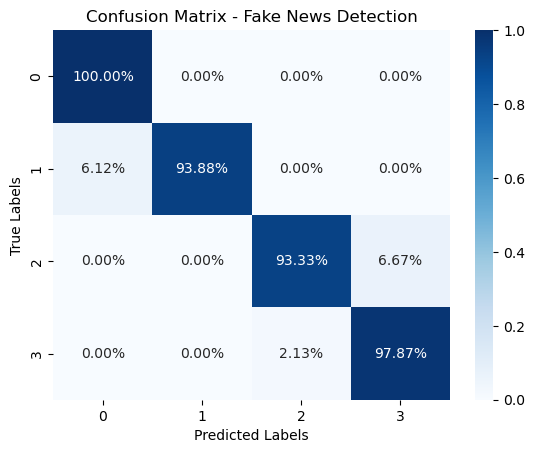

In [61]:
labels = ['Low Cost', 'Medium Cost', 'High Cost', 'Very High Cost']

y_pred = np.rint(model.predict(X_val).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Supervised Learning

In [62]:
X = data.drop(columns=['price_range'])
Y = data['price_range']

# print(Counter(Y))
# # undersample = RandomUnderSampler()
# undersample = SMOTE()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# Y = to_categorical(Y)

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1800, 20)
(200, 20)


In [70]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    # ('bagging', bagging),
    # ('adaboost', adaboost),
    # ('gradient', gradient),
    # ('extraTress', extraTrees),
    # ('randomforest', randomForest),
    # ('decisionTree', decisionTree),
    # ('histGradientBoosting', histGradientBoosting),
    # ('XGB', XGB),
    # ('knn', knn),
    # ('pac', pac),
    ('linear', linear),
], n_jobs=-1)

In [71]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('linear', LogisticRegression(random_state=42))],
                   n_jobs=-1)

In [73]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  97.11 %
Test Score  :  97.5 %


In [112]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1309
           1       1.00      0.97      0.98      1305

    accuracy                           0.99      2614
   macro avg       0.99      0.99      0.99      2614
weighted avg       0.99      0.99      0.99      2614



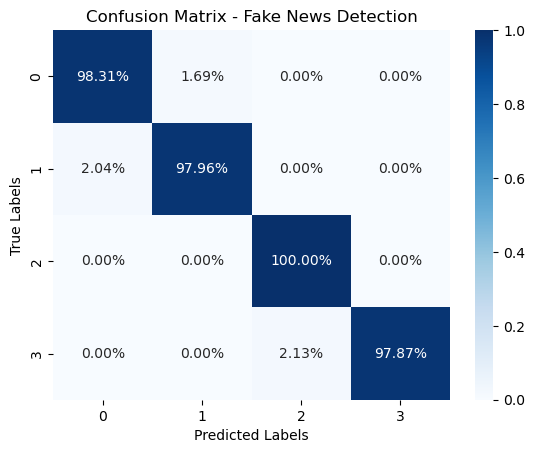

In [81]:
labels = ['Low Cost', 'Medium Cost', 'High Cost', 'Very High Cost']

y_pred = model.predict(X_val)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()